In [1]:
from astropy.io import fits
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import astropy
from astropy import wcs
from astroquery.ned import Ned
from astropy.visualization import astropy_mpl_style
plt.style.use(astropy_mpl_style)
from sklearn.linear_model import RANSACRegressor
from sklearn.datasets import make_regression
import matplotlib as mat
from astropy.stats import median_absolute_deviation as MAD

gzip was not found on your system! You should solve this issue for astroquery.eso to be at its best!
On POSIX system: make sure gzip is installed and in your path!On Windows: same for 7-zip (http://www.7-zip.org)!


In [2]:
wide_band_file = "C:/Users/emily/Documents/ARC Summer 2019/FITS files/NGC_4203_hst_9788_72_acs_wfc_f814w_drz.fits"
narrow_band_file = "C:/Users/emily/Documents/ARC Summer 2019/FITS files/NGC_4203_hst_9788_72_acs_wfc_f658n_drz.fits"
galaxy = "NGC4203"

In [3]:
with fits.open(wide_band_file) as wbf:
    wide_band_hdr = wbf[1].header
    wide_band = wbf[1].data*wide_band_hdr['photflam']
with fits.open(narrow_band_file) as nbf:
    narrow_band_hdr = nbf[1].header
    narrow_band = nbf[1].data*narrow_band_hdr['photflam']

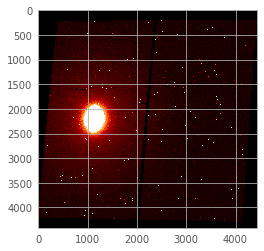

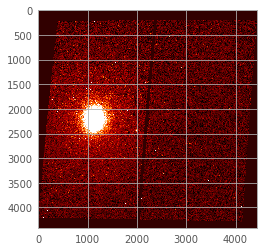

In [4]:
plt.imshow(wide_band, vmin=np.percentile(wide_band, 1), vmax=np.percentile(wide_band, 99))
plt.show()
plt.imshow(narrow_band, vmin=np.percentile(narrow_band, 1), vmax=np.percentile(narrow_band, 99))
plt.show()

Wide band center: 2203 1142


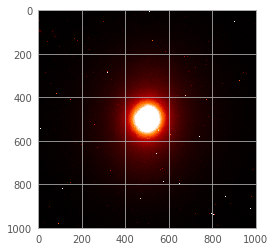

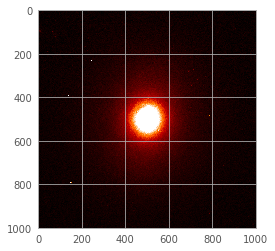

In [5]:
# crop the images around the galaxy
#wcs_wide=wcs.WCS(wide_band_hdr)
#wcs_narrow=wcs.WCS(narrow_band_hdr)

#result_table = Ned.query_object('NGC 4649')

#ra = result_table['RA'][0]
#dec = result_table['DEC'][0]

#center_w = wcs_wide.wcs_world2pix(ra, dec, 0)
#center_n = wcs_narrow.wcs_world2pix(ra, dec, 0)

xw = 2203
yw = 1142
delta = 500

print("Wide band center:",xw,yw)
#print("Narrow band center:",xn,yn)

wide_band_crop = wide_band[xw-delta:xw+delta,yw-delta:yw+delta]
narrow_band_crop = narrow_band[xw-delta:xw+delta,yw-delta:yw+delta]

plt.imshow(wide_band_crop, vmin=np.percentile(wide_band_crop, 1), vmax=np.percentile(wide_band_crop, 99))
plt.savefig("C:/Users/emily/Documents/ARC Summer 2019/Images/"+galaxy+"_wide_band.png")
plt.show()
plt.imshow(narrow_band_crop, vmin=np.percentile(narrow_band_crop, 1), vmax=np.percentile(narrow_band_crop, 99))
plt.savefig("C:/Users/emily/Documents/ARC Summer 2019/Images/"+galaxy+"_narrow_band.png")
plt.show()

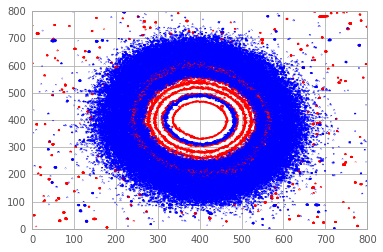

In [6]:
delta_2 = 400
plt.contour(wide_band[xw-delta_2:xw+delta_2,yw-delta_2:yw+delta_2], colors='red', levels=np.percentile(wide_band[np.where(wide_band !=0)],np.arange(99.2,99.9,0.1)))
plt.contour(narrow_band[xw-delta_2:xw+delta_2,yw-delta_2:yw+delta_2], colors='blue', levels=np.percentile(narrow_band[np.where(narrow_band!=0)],np.arange(98.8,99.95,0.35)))
plt.savefig("C:/Users/emily/Documents/ARC Summer 2019/Images/"+galaxy+"_contours")

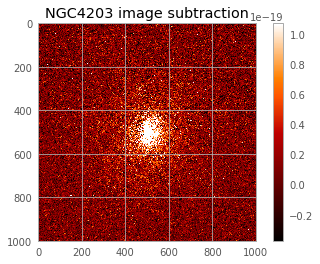

In [7]:
subtracted = narrow_band_crop-wide_band_crop
plt.imshow(subtracted, vmin=np.percentile(subtracted, 1), vmax=np.percentile(subtracted, 99))
plt.colorbar()
plt.title(galaxy+" image subtraction")
plt.savefig("C:/Users/emily/Documents/ARC Summer 2019/Images/"+galaxy+"_subtracted_crop.png")

In [8]:
# the version that works
r_inner = 100
r_outer = 150
center_x = delta
center_y = delta

wide_band_pixels = np.zeros(wide_band_crop.shape)
narrow_band_pixels = np.zeros(wide_band_crop.shape)

for x in range(wide_band_crop.shape[0]):
    for y in range(wide_band_crop.shape[1]):
        r = np.sqrt((x-center_x)**2+(y-center_y)**2)
        if r>r_inner and r<r_outer:
            wide_band_pixels[x,y] = wide_band_crop[x,y]
            narrow_band_pixels[x,y] = narrow_band_crop[x,y]
            
X = wide_band_pixels[np.nonzero(wide_band_pixels)].reshape(-1,1)
Y = narrow_band_pixels[np.nonzero(narrow_band_pixels)].reshape(-1,1)

a:  1.0443079584016788 b:  2.2828337430395438e-20


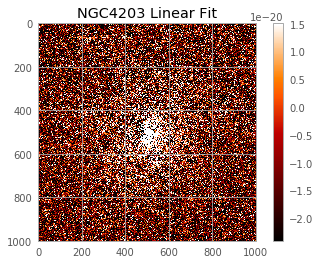

In [9]:
reg = RANSACRegressor(random_state=0).fit(X, Y)

a = float(reg.estimator_.coef_)
b = float(reg.estimator_.intercept_)
print("a: ", a, "b: ", b)
subtracted = narrow_band_crop-a*wide_band_crop-b*np.ones(wide_band_crop.shape)
plt.imshow(subtracted, vmin=np.percentile(subtracted, 30), vmax=np.percentile(subtracted, 90))
plt.colorbar()
plt.title(galaxy+" Linear Fit")
plt.savefig("C:/Users/emily/Documents/ARC Summer 2019/Images/"+galaxy+"_RANSAC_subtracted.png")

inliers:  0.8728213230047905


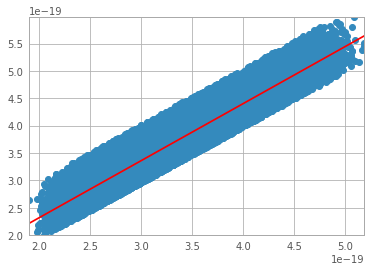

In [10]:
X_in = X[reg.inlier_mask_]
Y_in = Y[reg.inlier_mask_]
plt.scatter(X_in, Y_in)
plt.plot([0,1], [b, a+b], 'r')
plt.axis([X_in.min(), X_in.max(), Y_in.min(), Y_in.max()])
print("inliers: ", reg.inlier_mask_.sum()/reg.inlier_mask_.size)
plt.savefig("C:/Users/emily/Documents/ARC Summer 2019/Images/"+galaxy+"_fit.png")
plt.show()

In [11]:
#w_2 = 10
#subtracted_2 = np.zeros(subtracted.shape)

#for y in range(w_2, subtracted.shape[0]-w_2):
#    for x in range(w_2, subtracted.shape[1]-w_2):
#        avg = 0.0
#        for i in range(-w_2, w_2):
#            for j in range(-w_2, w_2):
#                avg = avg + subtracted[x+i,y+j]/(w_2*2.0)**2.0
#        subtracted_2[x,y] = avg

In [12]:
#plt.imshow(subtracted_2, vmin=np.percentile(subtracted_2, 30), vmax=np.percentile(subtracted_2, 99), cmap = mat.cm.jet)
#plt.colorbar()

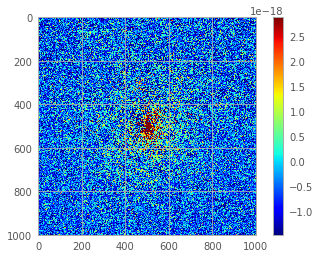

In [13]:
result_table = Ned.query_object('NGC 4203')

ra = result_table['RA'][0]
dec = result_table['DEC'][0]

full_image = subtracted*narrow_band_hdr['photbw']
hdr = narrow_band_hdr
hdr['CRPIX1'] = delta
hdr['CRPIX2'] = delta
hdr['CRVAL1'] = ra
hdr['CRVAL2'] = dec
hdr['ra_aper'] = ra
hdr['dec_aper'] = dec
hdr['bunit'] = 'erg/s/cm2'
hdr['goodmin'] = np.percentile(full_image, 10)
hdr['goodmax'] = np.percentile(full_image, 99.5)
hdr.set('target', 'NGC4203', 'target name')

hdu = fits.PrimaryHDU(data=full_image, header=hdr)
#hdu.writeto("C:/Users/emily/Documents/ARC Summer 2019/FITS files/Subtracted/"+galaxy+"_subtracted.fits")

plt.imshow(full_image, vmin=np.percentile(full_image, 10), vmax=np.percentile(full_image, 99.5), cmap=mat.cm.jet)
plt.colorbar()

Flux correction:  -3.6281015610958797e-19


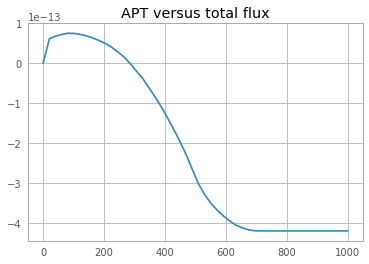

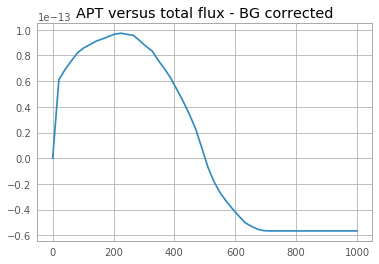

Max flux: 9.727134579582578e-14 pixel value: 224


In [26]:
# summing up the image for the total flux

y = np.arange(full_image.shape[0])
x = np.arange(full_image.shape[1])

xx, yy = np.meshgrid(x, y)
#plt.imshow(flux, vmin=np.percentile(narrow_band, 1), vmax=np.percentile(narrow_band, 99), cmap=mat.cm.jet)
#plt.colorbar()
fluxes = []
fluxes_corr = []

pix = np.linspace(0, full_image.shape[0], num=50)

for r in pix:
    z = (xx-delta)**2+(yy-delta)**2<r**2
    flux = (z*full_image).sum()
    fluxes.append(flux)

R = int(pix[-1]/2)
z = (xx-delta)**2+(yy-delta)**2<R**2
f_bg = (z*full_image).sum()/np.pi/R**2
print("Flux correction: ", f_bg)

bg_corr = full_image - f_bg*np.ones(full_image.shape)

for r in pix:
    z = (xx-delta)**2+(yy-delta)**2<r**2
    flux_corr = (z*bg_corr).sum()
    fluxes_corr.append(flux_corr)
    
plt.plot(pix, fluxes)
plt.title("APT versus total flux")
plt.show()
plt.plot(pix, fluxes_corr)
plt.title("APT versus total flux - BG corrected")
plt.show()
print("Max flux:", max(fluxes_corr), "pixel value:", int(pix[fluxes_corr.index(max(fluxes_corr))]))

In [15]:
# subtracting out the background for the total flux
#smol_sq = [800, 825]
#r = 150
#a = np.pi*r*r

#z = (xx > smol_sq[0]) * (xx < smol_sq[1]) * (yy > smol_sq[0]) * (yy < smol_sq[1])
#smol_flux_pp = np.median(z*subtracted)
#smol_flux_pp = smol_flux/(25**2)
#print("Bg flux per pixel:", smol_flux_pp)

#z = (xx-delta)**2 + (yy-delta)**2 < r**2
#big_flux = (z*full_image).sum()
#extra = smol_flux_pp*a
#flux = big_flux-extra
#print("Flux:", flux)

MAD: 7.064814672074213e-19 , Error:  1.0142866956875901e-16
Std:  2.3570326988244126e-18 , Error:  3.383962663830657e-16


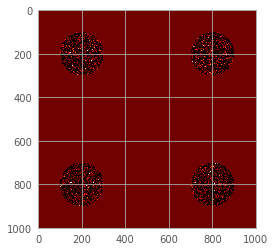

In [16]:
# calculate standard deviation
f = max(fluxes)
r = int(pix[fluxes.index(max(fluxes))])
w = 100
offset = 300
apt = int(pix[fluxes.index(max(fluxes))])

z1 = (xx-delta-offset)**2+(yy-delta-offset)**2 < w**2
z2 = (xx-delta+offset)**2+(yy-delta-offset)**2 < w**2
z3 = (xx-delta+offset)**2+(yy-delta+offset)**2 < w**2
z4 = (xx-delta-offset)**2+(yy-delta+offset)**2 < w**2
z = z1+z2+z3+z4

noise_pixels = (z*full_image).flatten()
noise_pixels = noise_pixels[np.where(noise_pixels!=0)]

apt_size = np.pi*(apt**2)

k = 1.4826
mad = k*MAD(noise_pixels)
std = np.std(noise_pixels)
plt.imshow(z*full_image, vmin=np.percentile(full_image, 30), vmax=np.percentile(full_image, 99))
print("MAD:", mad, ", Error: ", mad*np.sqrt(apt_size))
print("Std: ", std, ", Error: ", std*np.sqrt(apt_size))

In [29]:
a_err = mad /np.sqrt(std)

b_err = mad * np.sqrt( (noise_pixels**2).mean()/std)

print("Slope error: ", a_err, ", Intercept error: ", b_err)

z = (xx-delta)**2+(yy-delta)**2<r**2
wide_ap = (z*wide_band_crop).sum()
sys_err = np.sqrt(a_err**2 * wide_ap + b_err**2)

print("Systematic error: ", sys_err)

Slope error:  4.6016964799411355e-10 , Intercept error:  1.1149022553009723e-27
Systematic error:  1.5422469297803034e-16
